In [1]:
#UTF-8
%matplotlib inline
from fastai import *
from fastai.vision import *

# SGD for Mnist
https://course.fast.ai/videos/?lesson=5

In [2]:
path = Path('data')
path.ls()

[PosixPath('data/fireandsmoke1'), PosixPath('data/mnist.pkl.gz')]

In [3]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

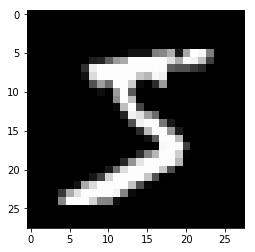

In [4]:
plt.imshow(x_train[0].reshape(28,28),cmap='gray')
x_train.shape

In [5]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c =x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [6]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs = bs)

In [7]:
x, y = next(iter(data.train_dl)) # iteration, DataBunch.create dataloader which straightly gives us the next thing we want
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [8]:
# class Mnist_logistic(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lin = nn.Linear(784, 10, bias = True)
        
#     def forward(self, xb):
#         return self.lin(xb)
    
############################################

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [9]:
model = Mnist_NN()
# model = Mnist_logistic()
model

Mnist_NN(
  (lin1): Linear(in_features=784, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
loss_func = nn.CrossEntropyLoss() # it does softmax inside, so it is accually softmax then cross entropy loss

We need something we're predicting the right thing correctly and confidently, which should have very little loss. Predicting the wrong thing confidently should have alot of loss.  
Sum up all one hot coded variables, times, all of your activations.  
To make sure it add up to 1, we need use the **SOFTMAX** activations.  
* For single label multi-class classification.

* Weight Decay
\begin{align}
w_t &= w_{t-1} - lr\cdot \frac{dL}{dw_{t-1}}\\
L(x, w) &= Loss(\text{model}(x, w), y)+wd\sum w^2\\
\begin{cases}
Loss1 = (\hat y - y)^2.\text{mean()}\cdots \text{MSE}\\
Loss2 = \text{CrossEntropyLoss()}
\end{cases}
\end{align}

# Optim: Dynamic Learning Rate

In [11]:
# def update(x, y, lr):
#     wd = 1e-5
#     y_hat = model(x)
#     w2 = 0
#     # weight decay
#     for p in model.parameters(): w2 += (p**2).sum()
#     # add to regular loss
#     loss = loss_func(y_hat, y)+w2*wd
#     loss.backward()
#     with torch.no_grad():
#         for p in model.parameters():
#             p.sub_(lr*p.grad) # p -= lr*p.grad
#             p.grad.zero_()
#     return loss.item() # scaler, tensor, normal python number 

##############################################
# with optim, does the same thing
def update(x, y,lr):
    # using Adam to replace the SGD sowe can chage wd. Adam = momentum + RMSprop
    opt = optim.Adam(model.parameters(),lr) 
#     opt = optim.SGD(model.parameters(),lr) 
    # RMSprop from Hinton. 0.9*previerse value + 0.1*GD^2
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step
    opt.zero_grad()
    return loss.item()

In [12]:
losses = [update(x, y, lr=1e-2) for x,y in data.train_dl]

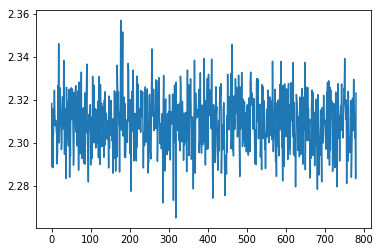

In [13]:
plt.plot(losses)

In [14]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


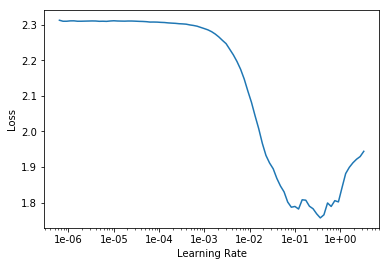

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.153851,0.132056,0.963500,00:16


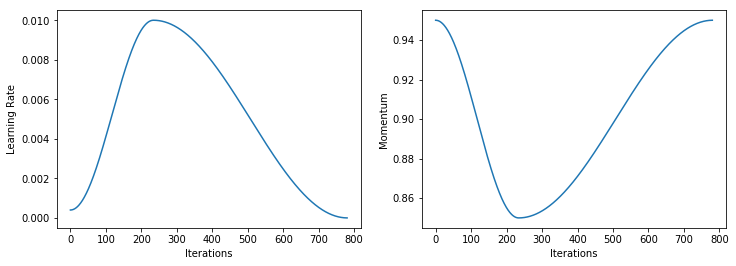

In [19]:
learn.recorder.plot_lr(show_moms=True)

**Citation Leslie Smith 2018!!!**

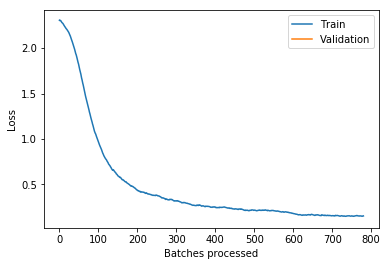

In [20]:
learn.recorder.plot_losses()
# this figure of FASTAI calculates the exponentially weighted moving average of the losses (指数加权)